# Bakersfield PM2.5 Prediction
 This notebook focuses on obtaining the best subset of the database for Bakersfield city in California to train a model for predicting PM2.5 concentration in the air.<br>
 
<img src="images/reference.png" alt="" style="width:450px;"> 
<img src="images/city.png" alt="" style="width:450px;">

# Merge the Data

In [ ]:
import pandas as pd

dfs = {}

for i in range(1999, 2025):
    dfs[f"df{i-1998}"] = pd.read_csv(f"data_raw/pm25_{i}.csv")

data = pd.concat(dfs.values(), ignore_index=True, verify_integrity=True)

data.to_csv('data_mod/data_merge.csv', index=False) 



## Check the Data

All the data in Bakersfield

In [ ]:
all((data['CBSA_NAME'].unique())=='Bakersfield, CA')

Split Bakersfield sites

In [ ]:
equal = data['Site Name'].nunique() == data['Site ID'].nunique()

if equal:
    print("IDs=Sites Names.")
else:
    print("IDs!=Sites Names.")


for i, (site_id, group) in enumerate(data.groupby('Site ID'), start=1):
    filename = f"data_mod/id_{i}.csv"
    group.to_csv(filename, index=False)


The site with the most data on Bakersfield

In [ ]:
num_rows_per_id = []

for site_id in range(1, 13):
    filename = f"data_mod/id_{site_id}.csv"
    df = pd.read_csv(filename)
    
    num_rows = len(df)
    num_rows_per_id.append(num_rows)

    print(f"The DataFrame for 'Site ID' {site_id} has {num_rows} rows.")


Check duplitcates

In [ ]:
import pandas as pd

# Load the DataFrame from the CSV file
data = pd.read_csv("data_mod/id_3.csv")

data_original = data.copy()

data_unique = data.drop_duplicates()

print(f'DataFrame original shape: {data_original.shape}')
print(f'data unique shape: {data_unique.shape}')

# Select  data (and Start modules)

##### Select Data (Start modules)

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("data_mod/id_3.csv")

data_mod = data[ ['Date', 'Daily Mean PM2.5 Concentration']].copy()
data_mod.rename(columns={'Daily Mean PM2.5 Concentration': 'pm25', 'Date': 'day'}, inplace=True)
data_mod['day'] = pd.to_datetime(data_mod['day'], format='%m/%d/%Y', errors='coerce')
data_mod.sort_values(by='day', inplace=True)
data_mod.set_index(['day'], inplace=True, drop=False)


In [198]:
data_mod.head()

,day,pm25
day,,
1999-01-03,1999-01-03,49.0
1999-01-06,1999-01-06,43.0
1999-01-06,1999-01-06,46.0
1999-01-09,1999-01-09,73.0
1999-01-12,1999-01-12,74.0


##### Data Plot

Text(0, 0.5, 'pm25')

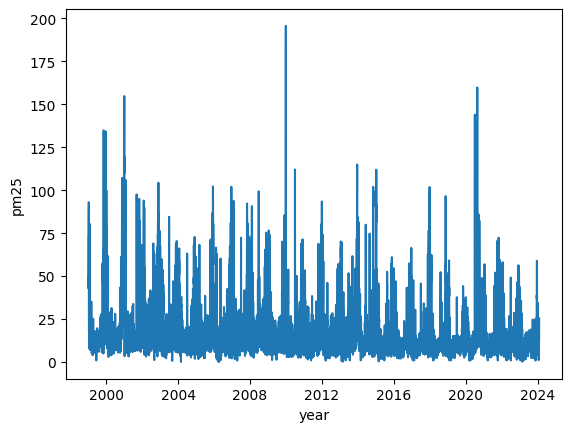

In [130]:
plt.plot(data_mod['day'], data_mod['pm25'])
plt.xlabel('year')
plt.ylabel('pm25')

##### Data Temporal Resizing

In [200]:




time_freq = "20D"

data_mod = data_mod.resample(time_freq).mean()

# Criar um novo índice de datas com a frequência desejada, começando na primeira data e terminando na última data dos dados
data_mod.set_index(['day'], inplace=True, drop=False)
data_mod.head()




,day,pm25
day,,
1999-01-12 00:00:00.000000000,1999-01-12 00:00:00.000000000,50.500000
1999-02-03 09:52:56.470588288,1999-02-03 09:52:56.470588288,29.717647
1999-02-22 19:30:00.000000000,1999-02-22 19:30:00.000000000,22.893750
1999-03-13 00:00:00.000000000,1999-03-13 00:00:00.000000000,12.661111
1999-04-04 06:51:25.714285696,1999-04-04 06:51:25.714285696,8.096429


In [206]:
nan_df = data_mod.isna()

# Verifique se há NaN em uma coluna específica (por exemplo, 'Date')
nan_date_column = data_mod['day'].isna()
nan_date_column

day
1999-01-12 00:00:00.000000000    False
1999-02-03 09:52:56.470588288    False
1999-02-22 19:30:00.000000000    False
1999-03-13 00:00:00.000000000    False
1999-04-04 06:51:25.714285696    False
                                 ...  
NaT                               True
2023-11-22 12:00:00.000000000    False
2023-12-12 12:00:00.000000000    False
2024-01-01 17:41:03.157894656    False
2024-01-21 00:00:00.000000000    False
Name: day, Length: 458, dtype: bool

##### Data split (train, val,test)

# Analisys

## PCA

In [201]:
from sklearn.decomposition import PCA

# Convert the date to Unix timestamps

data_mod['numerical_date'] = (data_mod['day'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Normalize the numerical columns
numeric_columns = ['numerical_date', 'pm25']
data_mod_numeric = data_mod[numeric_columns]
data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()


pca = PCA()
pca.fit(data_mod_normalized)

# Plot
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Proportion of Explained Variance by Principal Components')
plt.grid(True)
plt.show()
# Apply PCA
pca = PCA(n_components=2) 

principal_components = pca.fit_transform(data_mod_normalized)

print(pca.explained_variance_ratio_)  # Variance explained by each principal component

component_weights = pca.components_[1]  
temporal_cutoff = component_weights[1] / component_weights[0]  

print("Temporal cutoff interval:", temporal_cutoff)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## MPCA

In [15]:
import tensorly as tl
from tensorly.decomposition import parafac
import numpy as np

numeric_columns = ['numerical_date', 'pm25']
data_mod_numeric = data_mod[numeric_columns]
data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()
data_numerical_date = data_mod_normalized['numerical_date'].values.reshape(-1, 1, 1)
data_pm25 = data_mod_normalized['pm25'].values.reshape(-1, 1, 1)



tensor_data = tl.tensor(np.concatenate([data_numerical_date, data_pm25], axis=1))

print("Tensor_data Shape:", tensor_data.shape)

print("Type of tensor_data:", tensor_data.dtype)

# MPCA
components = parafac(tensor_data, rank=2)

# Extract components
component_1 = components.factors[0]  # Componente 1
component_2 = components.factors[1]  # Componente 2


ModuleNotFoundError: No module named 'tensorly'

In [38]:
print("explained_variance_ratio_ 1:", pca.explained_variance_ratio_[0])
print("explained_variance_ratio_ 2:", pca.explained_variance_ratio_[1])


explained_variance_ratio_ 1: 0.589376609550208
explained_variance_ratio_ 2: 0.41062339044979207


In [40]:
component_1_weights = component_1[:, 0] 
temporal_cutoff = component_1_weights[0] / component_1_weights[1]
print("temporal cut:", temporal_cutoff)

temporal cut: 1.1143663168059632


## MMI (Multivariate Mutual Information)

In [18]:
from sklearn.feature_selection import mutual_info_regression

x = data_mod_normalized[["numerical_date"]]  
y = data_mod_normalized["pm25"]  

mi_score = mutual_info_regression(x, y)[0]

print("Mutual Information between 'numerical_date' and 'pm25':", mi_score)

Mutual Information between 'numerical_date' and 'pm25': 0.3665967213000245


In [37]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

time = data_mod_normalized["numerical_date"].values.reshape(-1, 1)
pm25 = data_mod_normalized["pm25"].values

mutual_info = mutual_info_regression(time, pm25)


melhor_corte_temporal = time[np.`argmax(mutual_info)]
print(melhor_corte_temporal)
print(mutual_info )


[-1.83122359]
[0.36647713]


## (HE) Holt-Winters Exponential Smoothing

In [16]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = pd.read_csv("data_mod/id_3.csv")
data['Date'] = pd.to_datetime(data['Date'])
data_he = data[['Date', 'Daily Mean PM2.5 Concentration']].copy()

data_he['Date'] = pd.to_datetime(data_he['Date'])
data_he.set_index('Date', inplace=True)
time_freq=("20D")
data_he = data_he.resample(time_freq).mean() 
start_date = data_he.index[0]
end_date = data_he.index[-1]
idx = pd.date_range(start=start_date, end=end_date, freq=time_freq)
data_he = data_he.reindex(idx)

model = ExponentialSmoothing(data_he['Daily Mean PM2.5 Concentration'], seasonal_periods=12, trend=None, seasonal='add')

model_fit = model.fit()

n = 10  
forecast = model_fit.forecast(steps=n)
print(forecast)

ModuleNotFoundError: No module named 'statsmodels'

In [67]:
forecast.to_csv('data_mod/forecast.csv', index=False)

In [141]:
data_he.tail()

,Daily Mean PM2.5 Concentration
2023-10-24,13.906897
2023-11-13,12.650000
2023-12-03,25.080000
2023-12-23,15.331579
2024-01-12,13.089474


In [135]:
data.tail()

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
23316,2024-01-26,AirNow,60290014,3,8.1,ug/m3 LC,34,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23317,2024-01-27,AirNow,60290014,3,12.0,ug/m3 LC,50,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23318,2024-01-28,AirNow,60290014,3,23.2,ug/m3 LC,74,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23319,2024-01-29,AirNow,60290014,3,25.6,ug/m3 LC,79,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23320,2024-01-30,AirNow,60290014,3,12.8,ug/m3 LC,52,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
